# Global Terrorism EDA
_Replica of a fantastic EDA analysis [Terrorist Activities Around The World](https://www.kaggle.com/ash316/terrorism-around-the-world)_

The primary goal of this notebook is to get a good understanding of the tendencies underlying the data. Some secondary goals are:
* To practice plotting and data wrangling
* To learn how to plot maps and produce animations

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import folium

from mpl_toolkits.basemap import Basemap
from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [2]:
# preparing the data
data = pd.read_csv('../input/gtd/globalterrorismdb_0718dist.csv', encoding="ISO-8859-1")

# we also take some demographics data to see some population density charachteristics
population = pd.read_csv('../input/world-population-19602018/population_total_long.csv')
pop_density = pd.read_csv('../input/world-population-19602018/population_density_long.csv')

# make the data a little bit more tidy
pop_density.rename(columns={'Count': 'Density', 'Country Name':'Country'}, inplace=True)
data.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country',
                     'region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target',
                     'nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group',
                     'targtype1_txt':'TargetType','weaptype1_txt':'WeaponType','motive':'Motive',
                     'city':'City', 'latitude':'Latitude','longitude':'Longitude'},
            inplace=True)
terror = data[['Year','Month','Day','Country','Region','City','Latitude','Longitude','AttackType',
               'Killed','Wounded','Target','Summary','Group','TargetType','WeaponType','Motive']]

terror['Casualties'] = terror['Killed'] + terror['Wounded']
russia = terror[terror['Country'] == 'Russia']

`provstate` - province of the country

## Questioning the Data

First we need to decide what we would like to know. Having a lot of data is no good if you don't know what you want to get out of it.
My first inquiry is __whether overall terrorism situation is getting better or worse__, i.e:

* Do terrorist attacks become more or less frequent?
* Do average casualties per one terrorist attack get bigger or smaller?
* Do terrorists attacks per 100,000 population of the world get bigger or smaller?

The last subquestion seems important to me, because I think it is logical that as the population of the world increases the absolute number of terrorist attacks should also increase. And so if the number of attacks per 100 000 people would decrease but the absolute number would increase, it would still mean that the situation is getting better overall.

My second question is: __What is the distribution of terrorist attacks by casualties. It seems that this distribution should have a fat tail. My prior is that the distribution is lognormal__.

My third question is: What is the distribution of terrorist attacks by country and region.

* Are there any correlations with population density?

My fourth question is: __What are the primary targets of terrorists and are they changing over time?__

To start with let's see, what values are missing in our data:

In [3]:
n1 = terror.isnull().sum()
n2 = n1 / terror.shape[0]

miss_df = pd.concat((n1,n2),axis=1)
miss_df.columns = ['Missing', 'Percentage']
miss_df = miss_df.sort_values(by='Missing',ascending=False).round(2)

display(miss_df[miss_df['Missing']>0].T)

,Motive,Summary,Casualties,Wounded,Killed,Longitude,Latitude,Target,City
Missing,131130.00,66129.00,16874.00,16311.00,10313.00,4557.00,4556.00,636.0,434.0
Percentage,0.72,0.36,0.09,0.09,0.06,0.03,0.03,0.0,0.0


### Motives and summary
It seems like most of the time we don't know the motive of the terrorists attacks. And there are a lot of summary missing. But what do we see, when we know them?

In [4]:
motives_df = data['Motive'].value_counts(normalize=True).to_frame().rename(columns={'Motive':'Ratio'})
motives_df['Motive'] = motives_df.index
motives_df.reset_index(inplace=True, drop=True)
display(motives_df[['Motive','Ratio']].head())

,Motive,Ratio
0,Unknown,0.294476
1,The specific motive for the attack is unknown.,0.285398
2,"The specific motive is unknown; however, sourc...",0.005874
3,The specific motive for the attack is unknown..,0.002927
4,The specific motive for the attack is unknown ...,0.002848


This is somewhat interesting. Our data has 72% percent of `Motive` missing and when it is not missing about 60% of the time the "specific motive for the attack is unknown or was not reported". That is very suggestive of the fact that we don't know our enemy at all.

## Basic descriptive exploration

In [5]:
print('Country with maximum number of attacks: ', terror['Country'].value_counts().index[0])
print('Region with most number of attacks: ', terror['Region'].value_counts().index[0])
print('Maximum people killed in an attack are:', terror['Killed'].max(), 
      'that took place in ',terror.loc[terror['Killed'].idxmax()].Country,
      'in ', terror.loc[terror['Killed'].idxmax()].Year)
print('-'* 40)
a = terror.loc[(terror['Year'] == 2001) & 
               (terror['Month'] == 9) &
               (terror['Day'] == 11) & 
               (terror['Country'] == 'United States'),'Killed'].max()

print('For comparison during 9-11 there were killed', a)
print('-'*40)
print('Most people killed in Russia', russia.loc[russia['Killed'].idxmax()].Day,
      '-', russia.loc[russia['Killed'].idxmax()].Month,
      '-', russia.loc[russia['Killed'].idxmax()].Year,
      'when ', russia['Killed'].max(), 
      'were killed and',russia.loc[russia['Killed'].idxmax()].Wounded, 'were wounded')

Country with maximum number of attacks:  Iraq
Region with most number of attacks:  Middle East & North Africa
Maximum people killed in an attack are: 1570.0 that took place in  Iraq in  2014
----------------------------------------
For comparison during 9-11 there were killed 1384.0
----------------------------------------
Most people killed in Russia 1 - 9 - 2004 when  344.0 were killed and 727.0 were wounded


### Do terrorist attacks become more or less frequent?

In [6]:
world_pop = population.groupby(by='Year', as_index=False).sum().rename(columns={'Count':'Population'})
world_pop = world_pop[(world_pop['Year'] >= 1970) &
                      (world_pop['Year'] <= 2017) &
                      (world_pop['Year'] != 1993)].reset_index(drop=True)

In [7]:
by_year = terror.groupby(by='Year', as_index=False)['Country'].count().rename(columns={'Country':'Count'})
by_year['Casualties'] = terror.groupby(by='Year').sum().reset_index()['Casualties']
by_year = by_year.merge(world_pop, on='Year')
by_year['RelCount'] = by_year['Count'] / by_year['Population'] * 100000
by_year['RelCasualties'] = by_year['Casualties'] / by_year['Population'] * 100000
by_year['CasPerAttack'] = by_year['Casualties'] / by_year['Count']
display(by_year.head())

,Year,Count,Casualties,Population,RelCount,RelCasualties,CasPerAttack
0,1970,651,367.0,3668177898,0.017747,0.010005,0.563748
1,1971,471,119.0,3745511017,0.012575,0.003177,0.252654
2,1972,568,602.0,3821668158,0.014863,0.015752,1.059859
3,1973,473,621.0,3896922042,0.012138,0.015936,1.312896
4,1974,581,1122.0,3972857069,0.014624,0.028242,1.931153


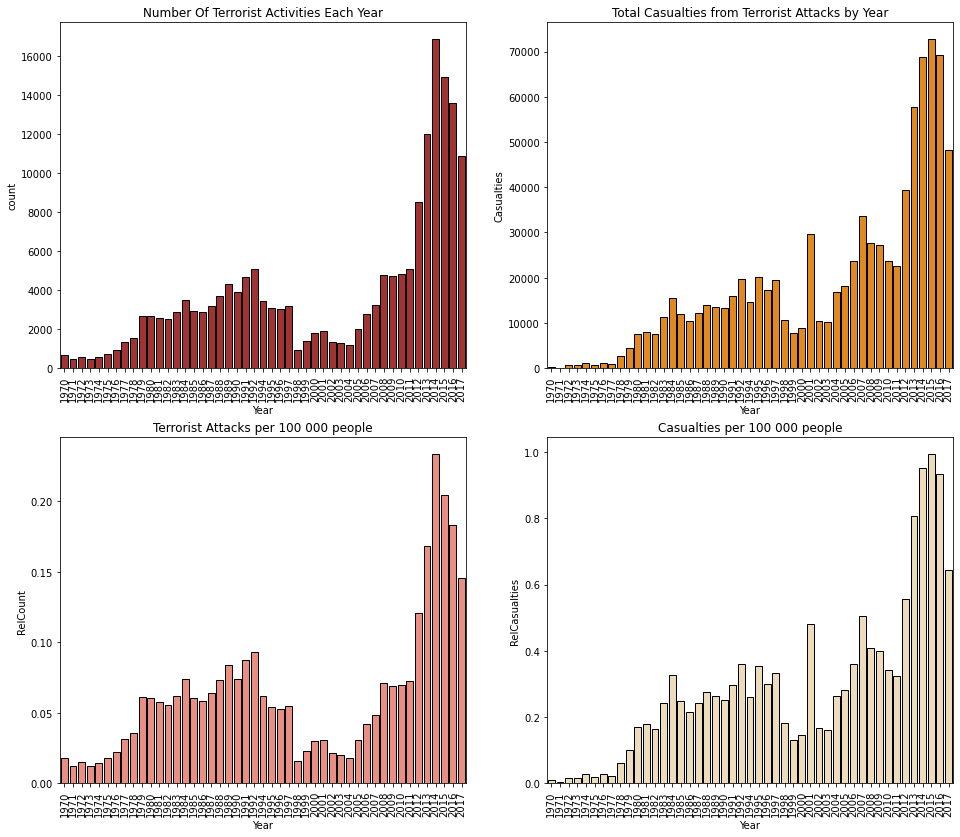

In [8]:
plt.rcParams['patch.force_edgecolor'] = True
plt.subplots(figsize=(16,14))

plt.subplot(221)
sns.countplot('Year', data=terror, color='firebrick')
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year')
plt.xticks(rotation=90)

plt.subplot(222)
sns.barplot(x='Year', y='Casualties', data=by_year, 
            color='darkorange')
plt.xticks(rotation=90)
plt.title('Total Casualties from Terrorist Attacks by Year')

plt.subplot(223)
sns.barplot(x='Year', y='RelCount',data=by_year,
            color='salmon')
plt.title('Terrorist Attacks per 100 000 people')
plt.xticks(rotation=90)
plt.subplot(224)
sns.barplot(x='Year', y='RelCasualties',data=by_year,
            color='wheat')
plt.title('Casualties per 100 000 people')
plt.xticks(rotation=90)
plt.show()

Now this is disturbing. Not only the number of attacks is increasing by year but also the frequency and deadliness of these attacks. And what about casualties per one attack during the year?

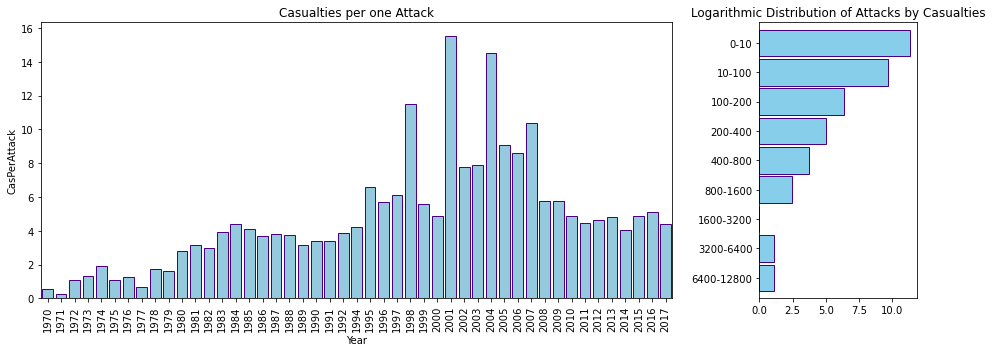

In [9]:
cas_distrib = pd.cut(terror['Casualties'], bins=[0, 10, 100, 200, 400, 800, 1600, 3200, 6400, 12800],
                    labels=['0-10','10-100','100-200','200-400','400-800', '800-1600','1600-3200',
                           '3200-6400','6400-12800']).value_counts().sort_index().to_frame()
cas_distrib['LogCasualties'] = np.log1p(cas_distrib['Casualties'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), gridspec_kw={'width_ratios': [4,1]})

sns.barplot(x='Year', y='CasPerAttack',data=by_year, ec = 'indigo', color='skyblue', ax=ax1)
ax1.set_title('Casualties per one Attack')
ax1.tick_params(axis='x',labelrotation=90)

cas_distrib['LogCasualties'].plot(kind='barh', width=0.9, ec='indigo', color='skyblue', ax=ax2)
ax2.invert_yaxis()
ax2.set_title('Logarithmic Distribution of Attacks by Casualties')

f.tight_layout()
plt.show()

We can see that there was an increased deadliness of attackd during the 2000s, but then average casualties during one attack went down, which may not be good news since the frequency of attacks more than quintupled since 2001. Also we can see that on a logarithmic scale number of casualties per one terrorist attack is almost linear. This is a distribution with a fat tail. We can make a guess that we have not yet seen the attack from the `12800-25600` bin category.

## Distribution by Region and Country
My next question is how these activities are distributed across the globe and whether the distribution is changing over time.

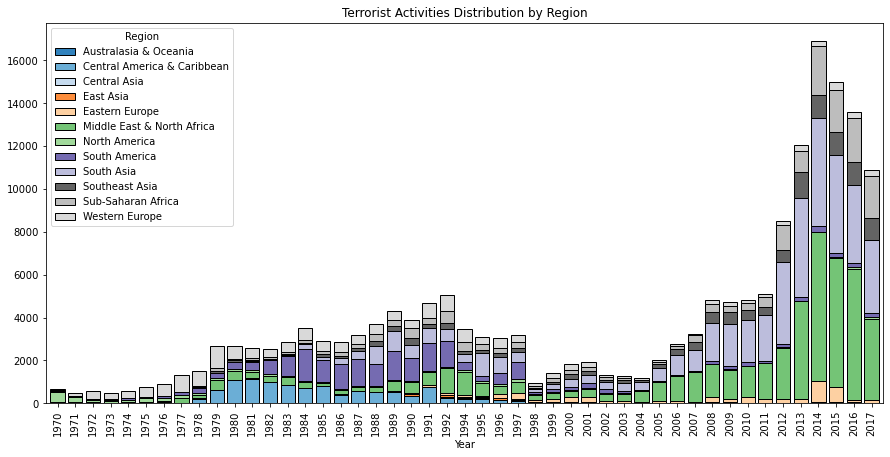

In [10]:
by_region = pd.crosstab(terror['Year'], terror['Region'])
by_region.plot(kind='bar', stacked=True, width=0.8, colormap='tab20c');
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.title("Terrorist Activities Distribution by Region")
plt.show()

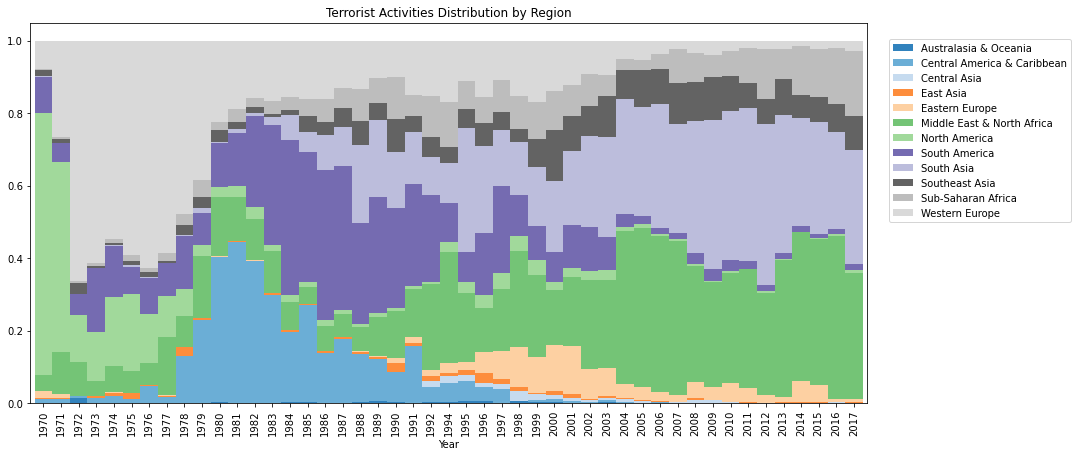

In [11]:
plt.rcParams['patch.force_edgecolor'] = False
by_region = pd.crosstab(terror['Year'], terror['Region'], normalize='index')
by_region.plot(kind='bar', stacked=True, width=1,colormap='tab20c');
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.title("Terrorist Activities Distribution by Region")
plt.legend(bbox_to_anchor=(1.02, 0.97), loc='upper left', ncol=1)
plt.show()

We can see massive increase in terrorist attacks in South Asia since 1980 and although terrorism in the Middle East & North Africa region was always present since 1970 both absolute and relative numbers greatly increased there since 1990s. Another salient region is Sub-Saharan Africa.

In [12]:
by_country = terror.groupby(by=['Year','Country'], as_index=False)['Month'].count()
by_country.rename(columns={'Month':'Count'},inplace=True)
by_country = by_country[['Country','Year','Count']]

merged_df = pop_density.merge(by_country, on=['Country','Year'])

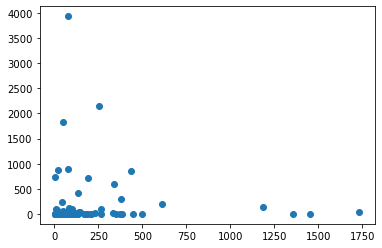

In [13]:
plt.scatter(x=merged_df.loc[merged_df['Year']==2014,'Density'],
            y=merged_df.loc[merged_df['Year']==2014,'Count']);

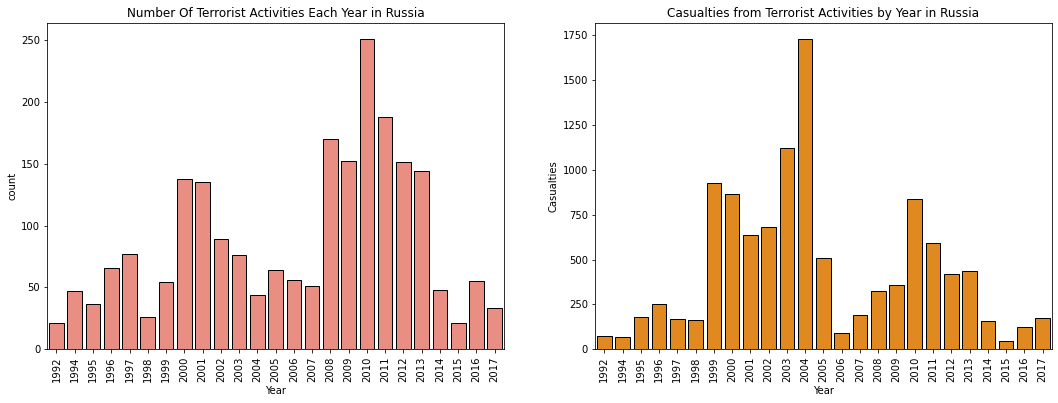

In [14]:
cas_yearly_rus = russia.groupby(by='Year', as_index=False)['Casualties'].sum()

plt.subplots(figsize=(18,6))

plt.subplot(121)
sns.countplot('Year', data=russia, color='salmon', edgecolor='k')
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year in Russia')

plt.subplot(122)
sns.barplot(x='Year', y='Casualties', data=cas_yearly_rus, 
        color='darkorange', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Casualties from Terrorist Activities by Year in Russia')
plt.show()

Yes, we can see that the number of terrorist activities have gone up after 2000. Though it may be the case, that the number of attacks increases, but the total number of casualties decreases. Let's plot and check this out.

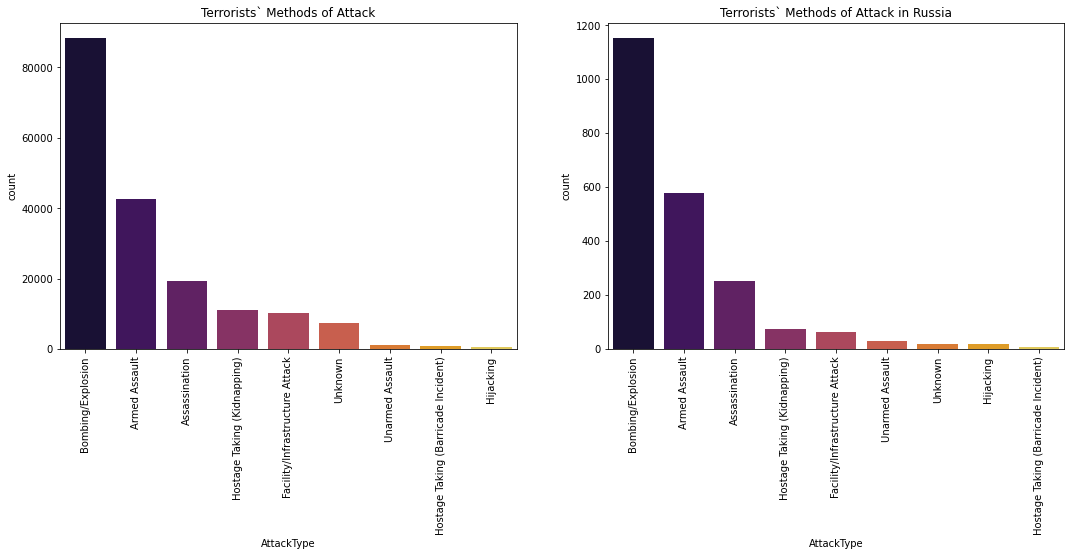

In [15]:
plt.subplots(figsize=(18,6))
plt.subplot(121)
sns.countplot('AttackType', data=terror, palette='inferno',
              order=terror['AttackType'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Terrorists` Methods of Attack')

plt.subplot(122)
sns.countplot('AttackType', data=russia, palette='inferno',
              order=russia['AttackType'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Terrorists` Methods of Attack in Russia')
plt.show()

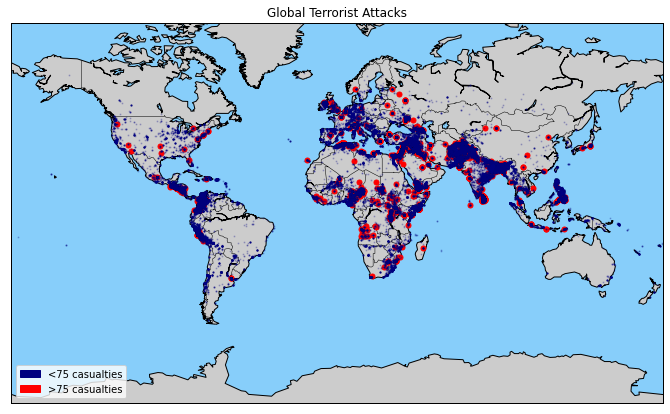

In [16]:
m3 = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180,
            lat_ts=20, resolution='c', lat_0=True, lat_1=True)
long_100 = list(terror[terror['Casualties']>=75]['Longitude'])
lat_100 = list(terror[terror['Casualties']>=75]['Latitude'])
x_100, y_100 = m3(long_100, lat_100)
m3.plot(x_100, y_100, 'go', markersize=5, color='r')

long_ = list(terror[terror['Casualties']<75]['Longitude'])
lat_ = list(terror[terror['Casualties']<75]['Latitude'])
x_, y_ = m3(long_, lat_)
m3.plot(x_, y_, 'go', markersize=1, color='navy', alpha=0.2)

m3.drawcoastlines()
m3.drawcountries()
m3.fillcontinents(lake_color='lightskyblue')
m3.drawmapboundary(fill_color='lightskyblue')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.title('Global Terrorist Attacks')
plt.legend(loc='lower left', handles=[mpatches.Patch(color='navy', label="<75 casualties"),
                                      mpatches.Patch(color='r', label=">75 casualties")])
plt.show()


In [17]:
terror_fol = terror.copy()
terror_fol.dropna(subset=['Latitude','Longitude'], inplace=True)
terror_fol.sort_index(ascending=False, inplace=True)
location_fol = terror_fol[['Latitude','Longitude']][:1000]
country_fol = terror_fol['Country'][:1000]
city_fol = terror_fol['City'][:1000]
year_fol = terror_fol['Year'][:1000]
month_fol = terror_fol['Month'][:1000]
day_fol = terror_fol['Day'][:1000]
killed_fol = terror_fol['Killed'][:1000]
wound_fol = terror_fol['Wounded'][:1000]

def color_point(x):
    if x>=30: color = 'red'
    elif ((x>0 and x<30)): color = 'blue'
    else: color = 'green'
    
    return color

def point_size(x):
    if (x>30 and x<100): size = 2
    elif (x>=100 and x<500): size = 8
    elif x>=500: size = 16
    else: size = 0.5
        
    return size

map_fol = folium.Map(location=[30,0], tiles='CartoDB dark_matter', zoom_start=2)
for point in location_fol.index:
    info = '<b>Country: </b>' + str(country_fol[point]) + \
           '<br><b>City: </b>' + str(city_fol[point]) + \
           '<br><b>Date: </b>' + str(year_fol[point]) + \
                           '-' + str(month_fol[point]) + \
                           '-' + str(day_fol[point]) + \
           '<br><b>Killed: </b>' + str(killed_fol[point]) + \
           '<br><b>Wounded: </b>' + str(wound_fol[point])
    iframe = folium.IFrame(html=info, width=200, height=200)
    folium.CircleMarker(list(location_fol.loc[point].values),
                       popup = folium.Popup(iframe),
                       radius = point_size(killed_fol[point]),
                       color = color_point(killed_fol[point])).add_to(map_fol)
    
map_fol

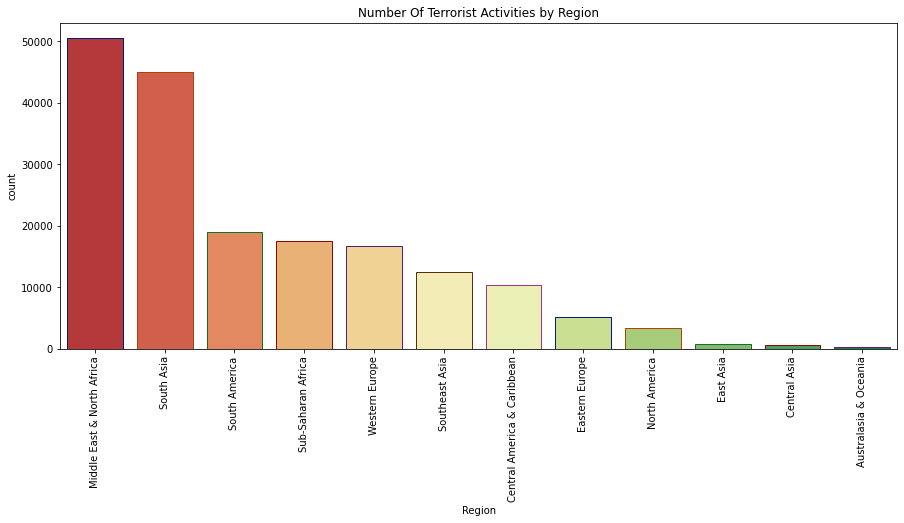

In [18]:
plt.subplots(figsize=(15,6))
sns.countplot('Region', data=terror, palette='RdYlGn', edgecolor=sns.color_palette('dark',7),
              order = terror['Region'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities by Region')
plt.show()

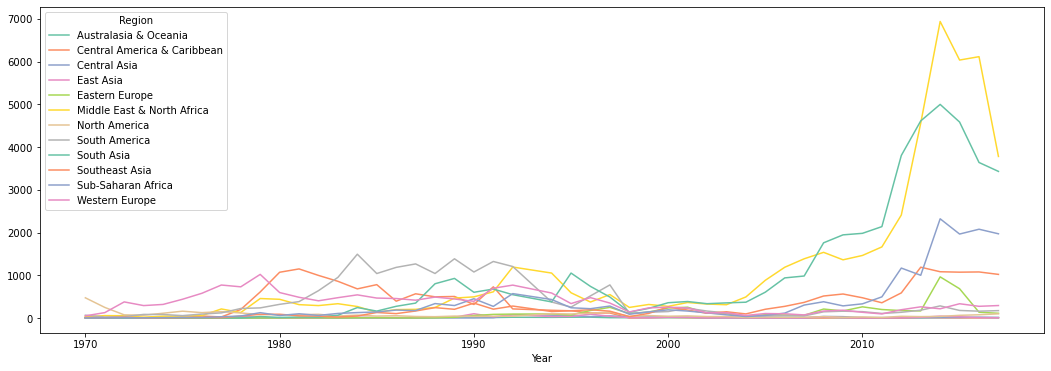

In [19]:
terror_region = pd.crosstab(terror['Year'], terror['Region'])
terror_region.plot(color=sns.color_palette('Set2', 12))
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.show()

In [20]:
cross_tab_exp = pd.crosstab(terror['Year'],terror['Region'], 
                            values=terror['Casualties'], aggfunc='sum',
                           margins='Total')
cross_tab_exp.head()

Region,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe,All
Year,,,,,,,,,,,,,
1970,0.0,3.0,NaN,0.0,0.0,6.0,194.0,15.0,24.0,54.0,1.0,70.0,367.0
1971,0.0,0.0,NaN,0.0,0.0,18.0,75.0,6.0,NaN,12.0,1.0,7.0,119.0
1972,1.0,0.0,NaN,NaN,26.0,116.0,53.0,7.0,0.0,85.0,0.0,314.0,602.0
1973,0.0,0.0,NaN,0.0,8.0,25.0,79.0,35.0,1.0,8.0,4.0,461.0,621.0
1974,0.0,0.0,NaN,8.0,1.0,207.0,72.0,47.0,2.0,5.0,3.0,777.0,1122.0


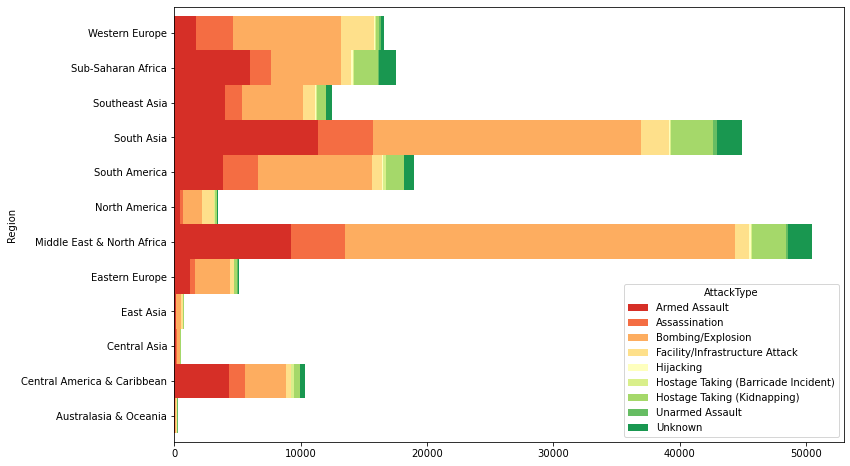

In [21]:
pd.crosstab(terror.Region, terror.AttackType).plot.barh(stacked=True, width=1, 
                                                        color=sns.color_palette('RdYlGn', 9))
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

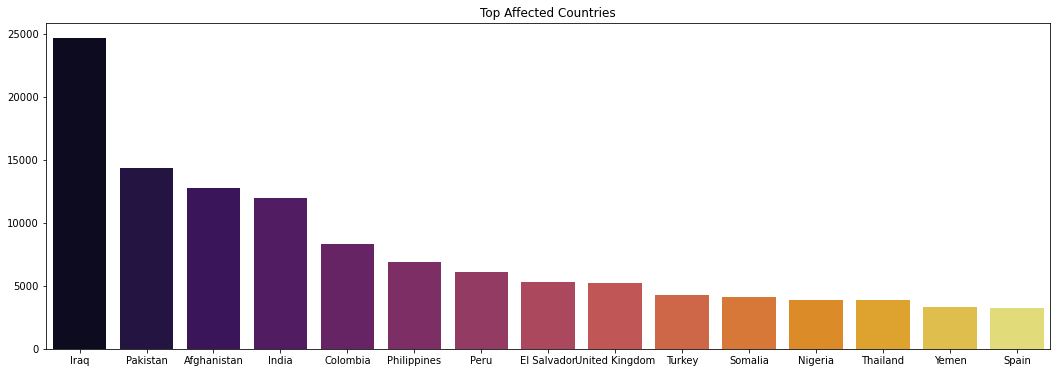

In [22]:
plt.subplots(figsize = (18,6))
sns.barplot(terror['Country'].value_counts().index[:15],
            terror['Country'].value_counts().values[:15],
            palette='inferno')
plt.title('Top Affected Countries')
plt.show()

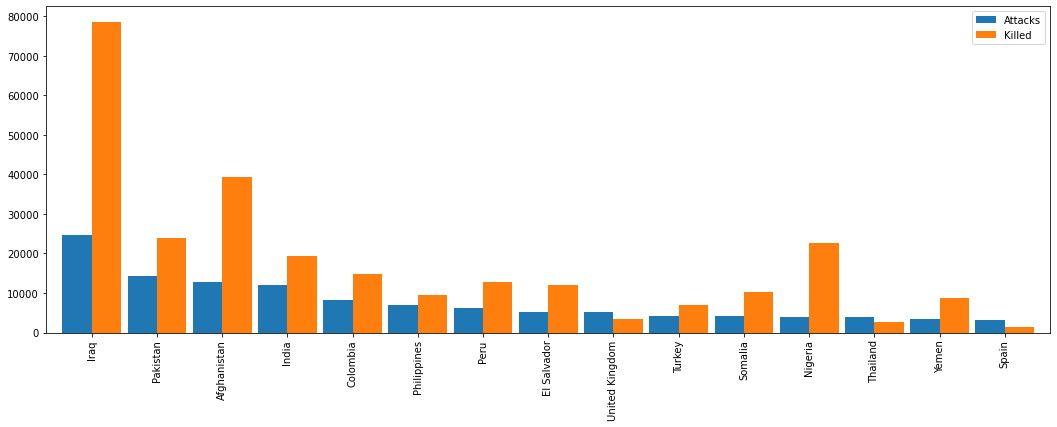

In [23]:
coun_terror = terror['Country'].value_counts()[:15].to_frame()
coun_terror.columns = ['Attacks']
coun_kill = terror.groupby('Country')['Killed'].sum().to_frame()
coun_terror.merge(coun_kill, left_index=True, right_index=True, how='left').plot.bar(width=0.9)
fig = plt.gcf()
fig.set_size_inches(18,6)
plt.show()

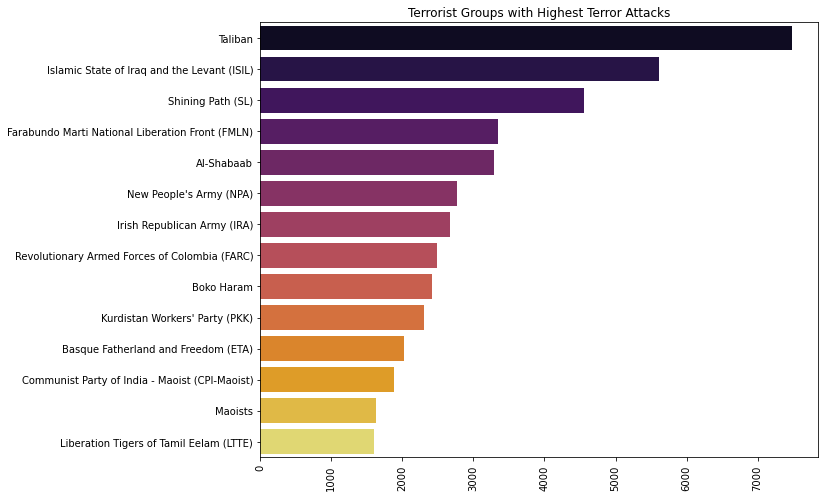

In [24]:
sns.barplot(terror['Group'].value_counts()[1:15].values, 
            terror['Group'].value_counts()[1:15].index,
            palette=('inferno'))
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.title('Terrorist Groups with Highest Terror Attacks')
plt.show()

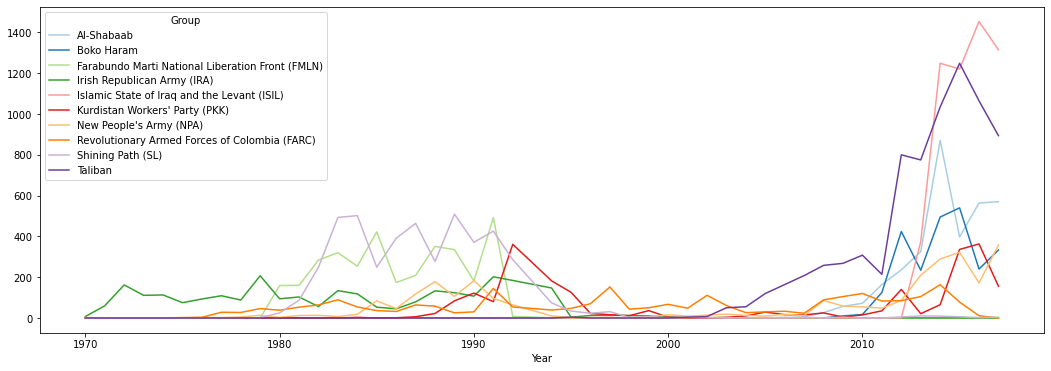

In [25]:
top_groups10 = terror[terror['Group'].isin(terror['Group'].value_counts()[1:11].index)]
pd.crosstab(top_groups10['Year'],top_groups10['Group']).plot(color=sns.color_palette('Paired', 10))
fig = plt.gcf()
fig.set_size_inches(18,6)
plt.show()

In [26]:
russia_fol = russia.copy()
russia_fol.dropna(subset=['Latitude','Longitude'],inplace=True)
russia_fol.sort_index(ascending=False, inplace=True)

location_rus = russia_fol[['Latitude','Longitude']][:1000]
city_rus = russia_fol['City'][:1000]
year_rus = russia_fol['Year'][:1000]
month_rus = russia_fol['Month'][:1000]
day_rus = russia_fol['Day'][:1000]
killed_rus = russia_fol['Killed'][:1000]
wound_rus = russia_fol['Wounded'][:1000]
target_rus = russia_fol['TargetType'][:1000]

map_rus = folium.Map(location=[55.75, 37.62], tiles='CartoDB dark_matter', zoom_start=3)
for point in location_rus.index:
    info = '<br><b>City: </b>' + str(city_rus[point]) + \
           '<br><b>Date: </b>' + str(year_rus[point]) + \
                           '-' + str(month_rus[point]) + \
                           '-' + str(day_rus[point]) + \
           '<br><b>Killed: </b>' + str(killed_rus[point]) + \
           '<br><b>Wounded: </b>' + str(wound_rus[point]) + \
           '<br><b>Target: </b>' + str(target_rus[point])
    iframe = folium.IFrame(html=info, width=200, height=200)
    folium.CircleMarker(list(location_rus.loc[point].values),
                       popup = folium.Popup(iframe),
                       radius = point_size(killed_rus[point]),
                       color = color_point(killed_rus[point])).add_to(map_rus)
map_rus